### Import Packages

In [55]:
import pandas as pd
import numpy as np
from scipy import stats

# clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from pathlib import Path
from tqdm import tqdm
import importlib
import module
try:
    importlib.reload(module) # reload module
except NameError:
    pass

### Import Data

In [28]:
path= Path('data/clean/clean_data.parquet')
cols = list(pd.read_parquet(path))
print(cols)

['id', 'age', 'education', 'marital_status', 'income', 'is_parent', 'kidhome', 'teenhome', 'dt_customer', 'dt_customer_day', 'dt_customer_dow', 'dt_customer_wom', 'dt_customer_month', 'dt_customer_year', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods', 'total_spent', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases', 'total_purchase', 'num_web_visits_month', 'accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp6', 'num_deals_purchases', 'complain']


We will not read unused columns.

In [29]:
df= pd.read_parquet(path= path, columns= [col for col in cols if col not in[
    'id', 'dt_customer', 'dt_customer_day', 'dt_customer_dow', 'dt_customer_wom', 'dt_customer_month', 'dt_customer_year'
]])

### Hopkins Test

Now we we will use Hopkins Test to check if the data contains meaningful clusters.

In [30]:
columns= ['age', 'income', 'total_spent', 'total_purchase']
scaler= StandardScaler()

X= pd.DataFrame(df
    .pipe(module.drop_outliers, columns, 'z_score')
    .pipe(pd.get_dummies)
    .pipe(scaler.fit_transform)
)
module.hopkins_test(X)

Hopkins statistic=  0.896: there are meaningful clusters


### Select Algorithm and Number of Cluster

In [31]:
clusters= range(2, 6, 1)

models= []
n_clusters= []
silhouette_scores= []

def append_scores(model, i):
    n_clusters.append(i)
    models.append(type(model).__name__)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

for i in tqdm(clusters):
    
    # k-means
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        kmeans= KMeans(n_clusters= i, random_state= 8, init= 'k-means++', n_init= 10)
        cluster_labels= kmeans.fit_predict(X)
        append_scores(kmeans, i)

    # agglomerative clustering
    agglo= AgglomerativeClustering(n_clusters= i)
    cluster_labels= agglo.fit_predict(X)
    append_scores(agglo, i)

    # note: spectral clustering is very slow in this case
    # spectral= SpectralClustering(n_clusters= i, random_state= 8)
    # cluster_labels= spectral.fit_predict(X)
    # append_scores(spectral, i)

results= pd.DataFrame(data= {
    'model': models, 
    'n_clusters': n_clusters, 
    'silhouette_score': silhouette_scores
}).sort_values('silhouette_score', ignore_index= True)
results

100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


,model,n_clusters,silhouette_score
0,KMeans,5,0.111352
1,AgglomerativeClustering,3,0.128673
2,AgglomerativeClustering,4,0.139104
3,AgglomerativeClustering,5,0.151422
4,KMeans,4,0.170089
5,KMeans,3,0.172517
6,KMeans,2,0.241268
7,AgglomerativeClustering,2,0.246005


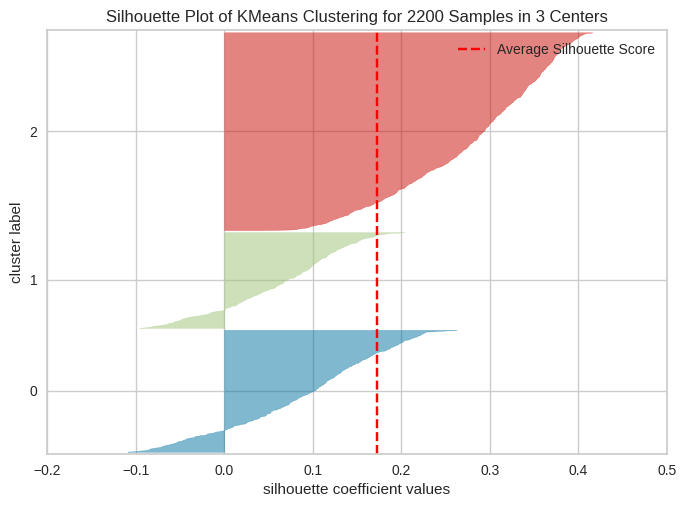

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    kmeans= KMeans(n_clusters= 3, random_state= 8, init= 'k-means++', n_init= 10)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show()
    plt.show()

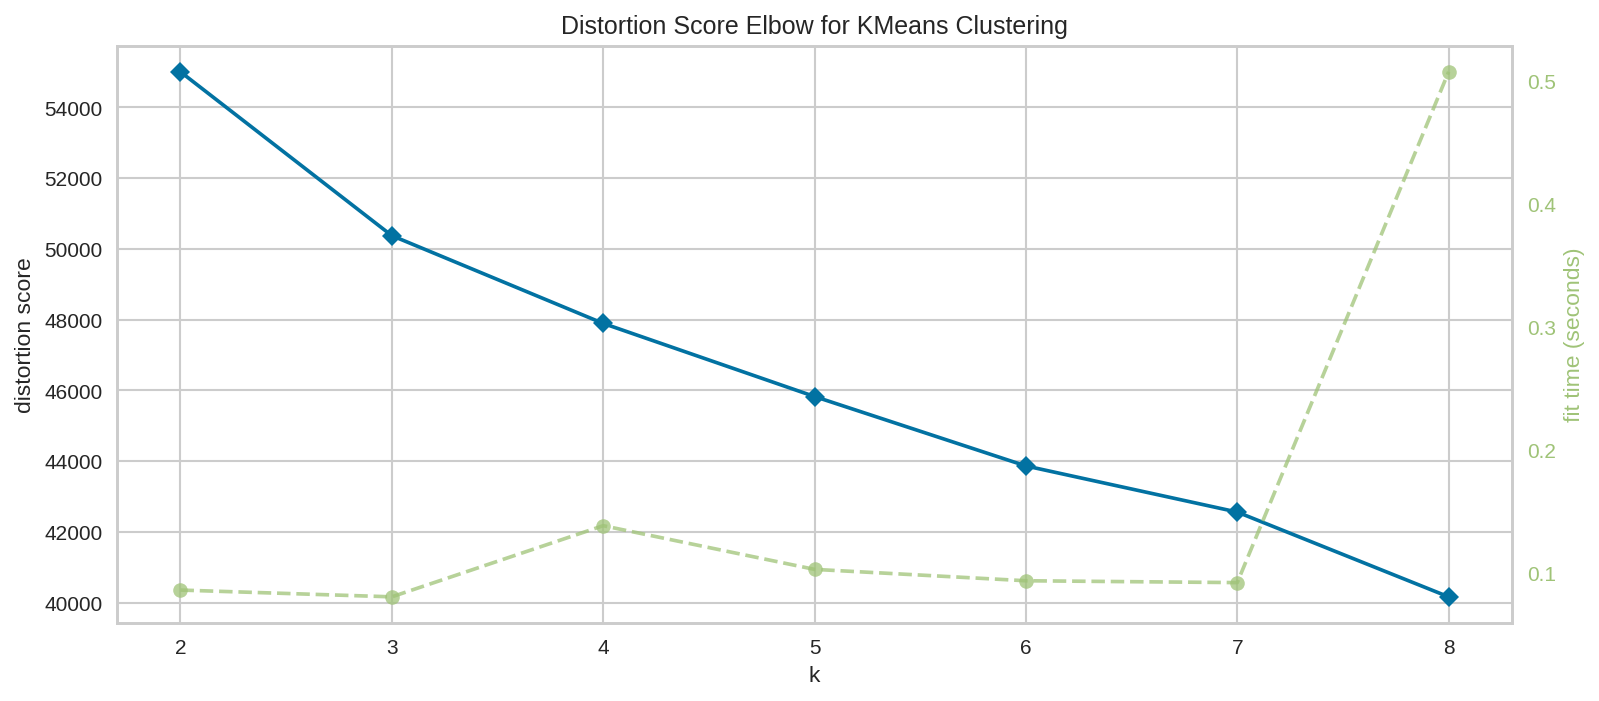

In [33]:
fig, ax= plt.subplots(figsize= (12, 5), dpi= 150)
fig.patch.set_facecolor('white')

kmeans= KMeans(n_clusters= 3, random_state= 8, init= 'k-means++', n_init= 10)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)

    visualizer = KElbowVisualizer(kmeans, k=(2, 9), metric= 'distortion', ax= ax)
    visualizer.fit(X)      
    visualizer.show()

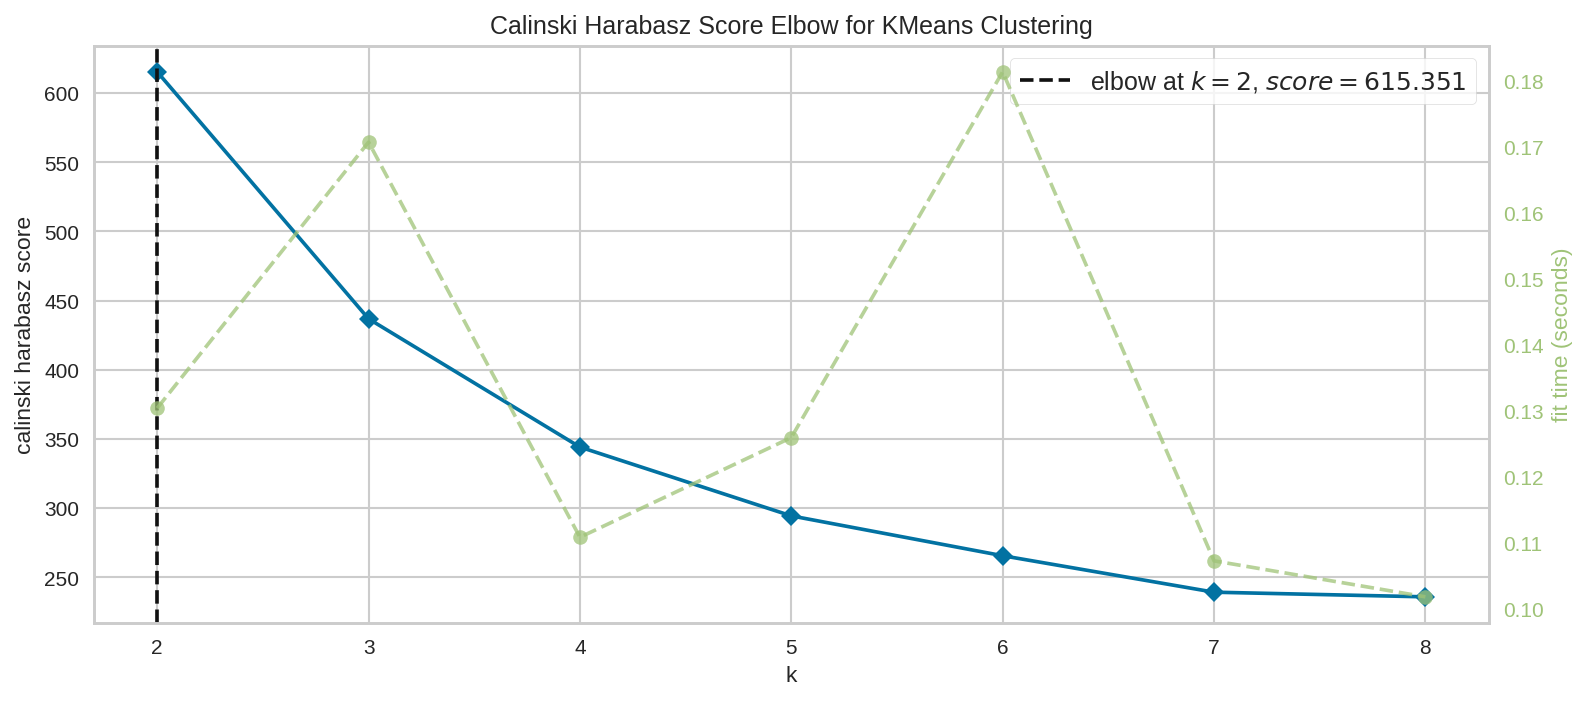

In [34]:
fig, ax= plt.subplots(figsize= (12, 5), dpi= 150)
fig.patch.set_facecolor('white')

kmeans= KMeans(n_clusters= 3, random_state= 8, init= 'k-means++', n_init= 10)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    
    visualizer = KElbowVisualizer(kmeans, k=(2, 9), metric= 'calinski_harabasz', ax= ax)
    visualizer.fit(X)      
    visualizer.show()

Based on numerous metrics above, I decided to select 3 clusters. Altough it's not perfect (as can be seen in silhouette plot), selecting too many clusters is not practical in real world application

### Segment Customers

Here, we will segment customers and directly assign them to our df.

In [35]:
kmeans= KMeans(n_clusters= 3, random_state= 8, init= 'k-means++', n_init= 10)
scaler= StandardScaler()

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    df= (df
        .pipe(module.drop_outliers, columns, 'z_score')
        .assign(
            segment= lambda df_: kmeans.fit_predict(
                df_.pipe(pd.get_dummies).pipe(scaler.fit_transform)
            )
        )
        # make segment categorical so that it is automatically sorted
        .assign(segment= lambda df_: df_['segment']
            .astype(pd.CategoricalDtype([0, 1, 2], ordered= True))
        )
    )

### Segment Profiling

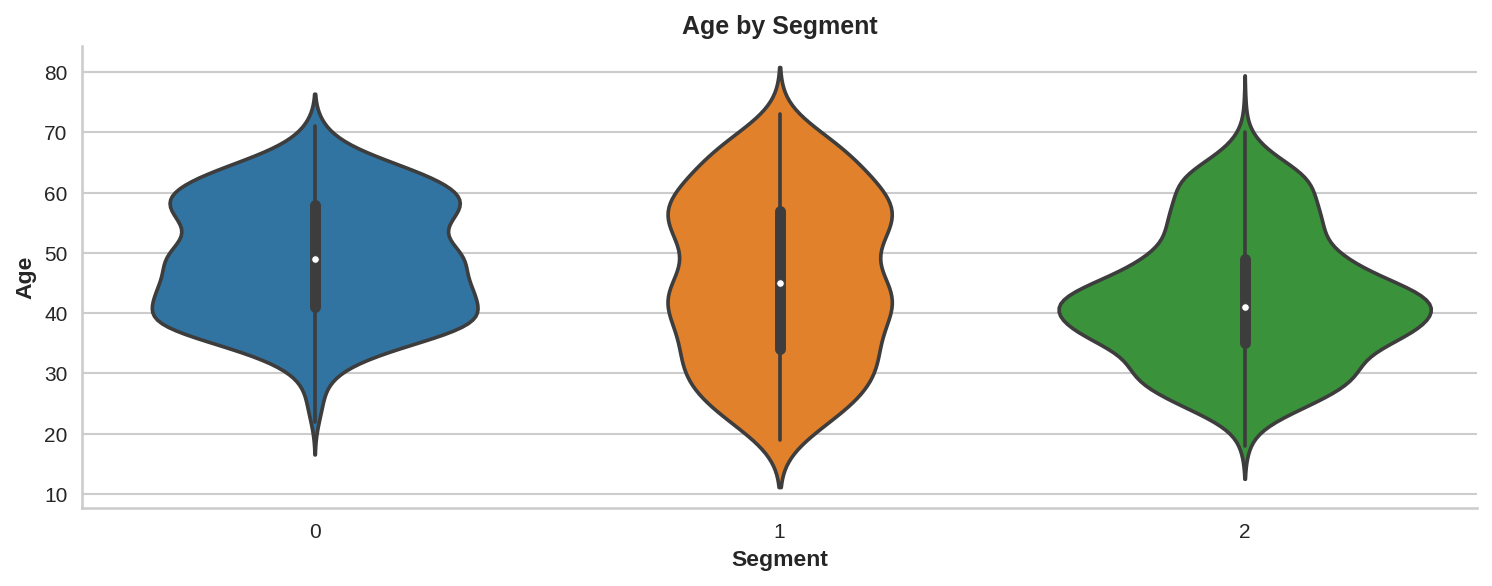

In [36]:
module.plot_violin(
    x= 'segment',
    y= 'age',
    df= df
)

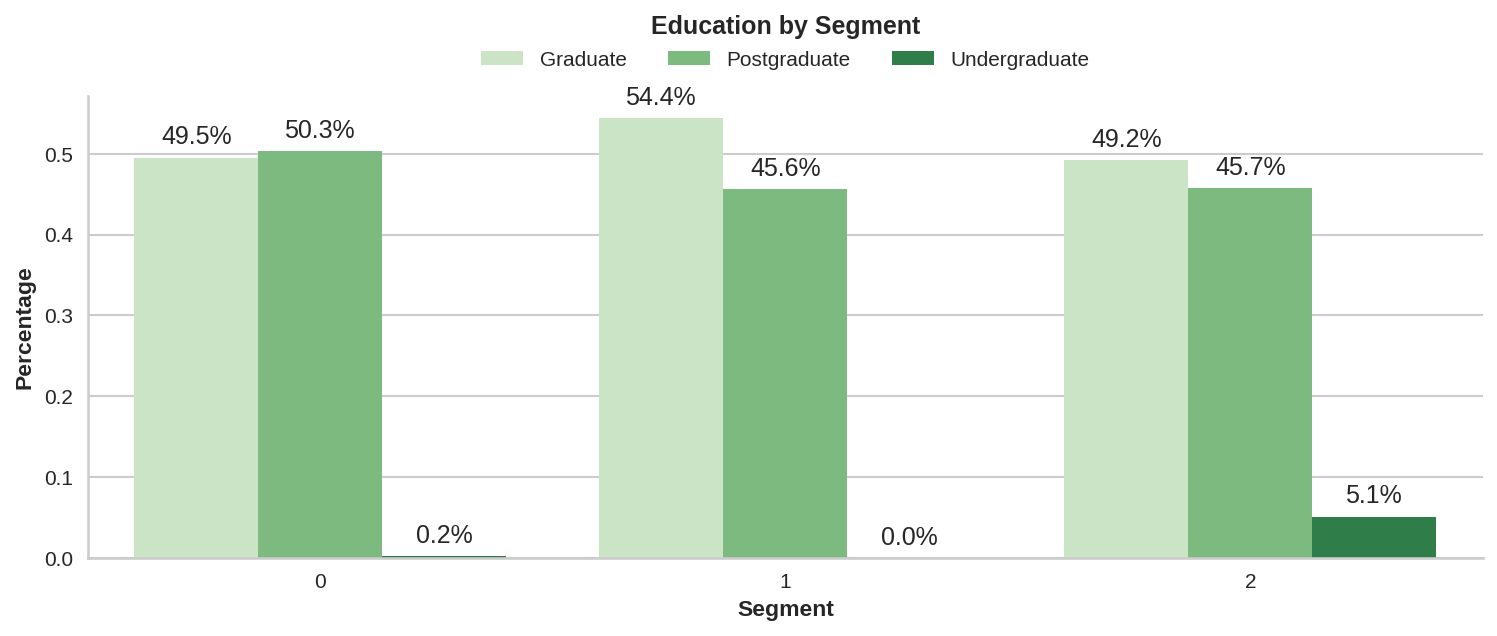

In [56]:
module.plot_bar_with_hue(
    hue= 'education', 
    df= df
)

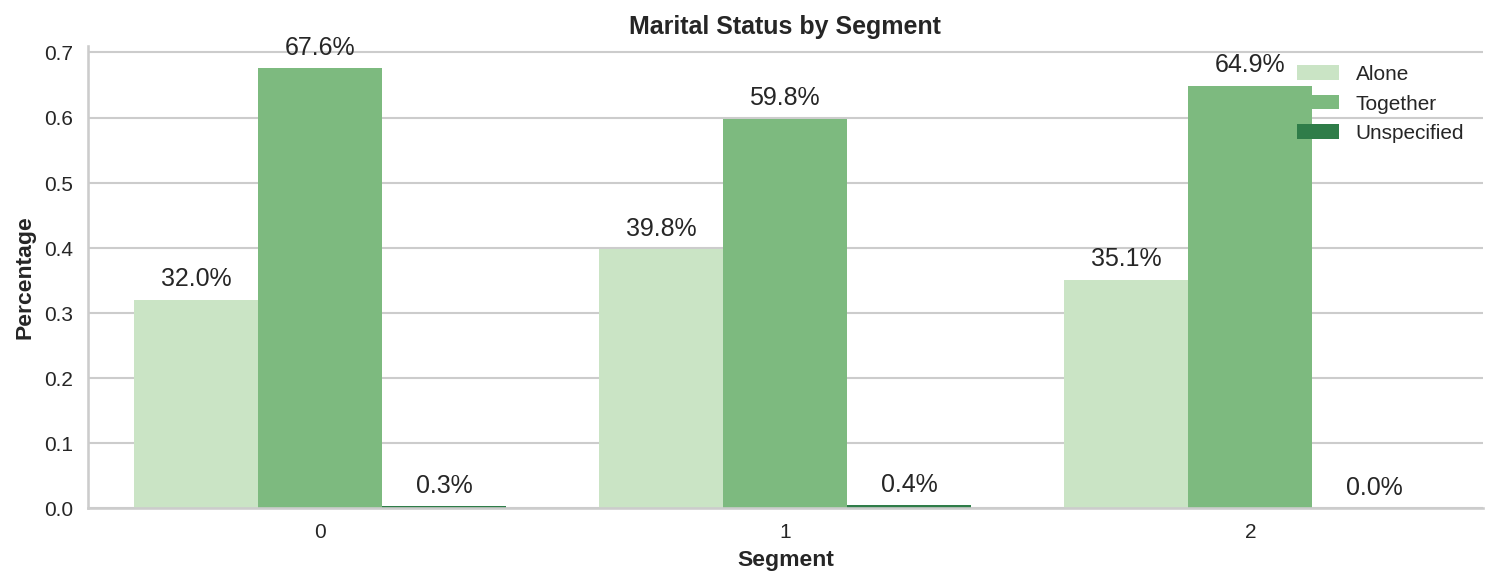

In [ ]:
module.plot_bar_with_hue(
    hue= 'marital_status', 
    df= df
)

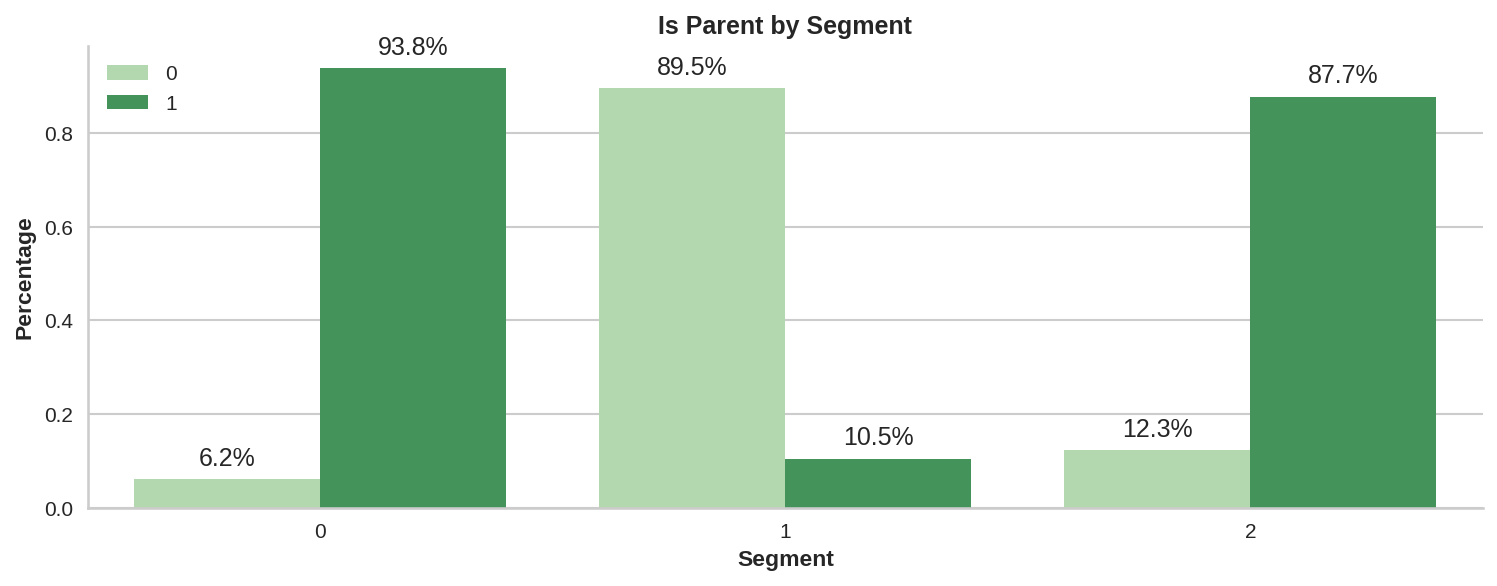

In [ ]:
module.plot_bar_with_hue(
    hue= 'is_parent', 
    df= df
)

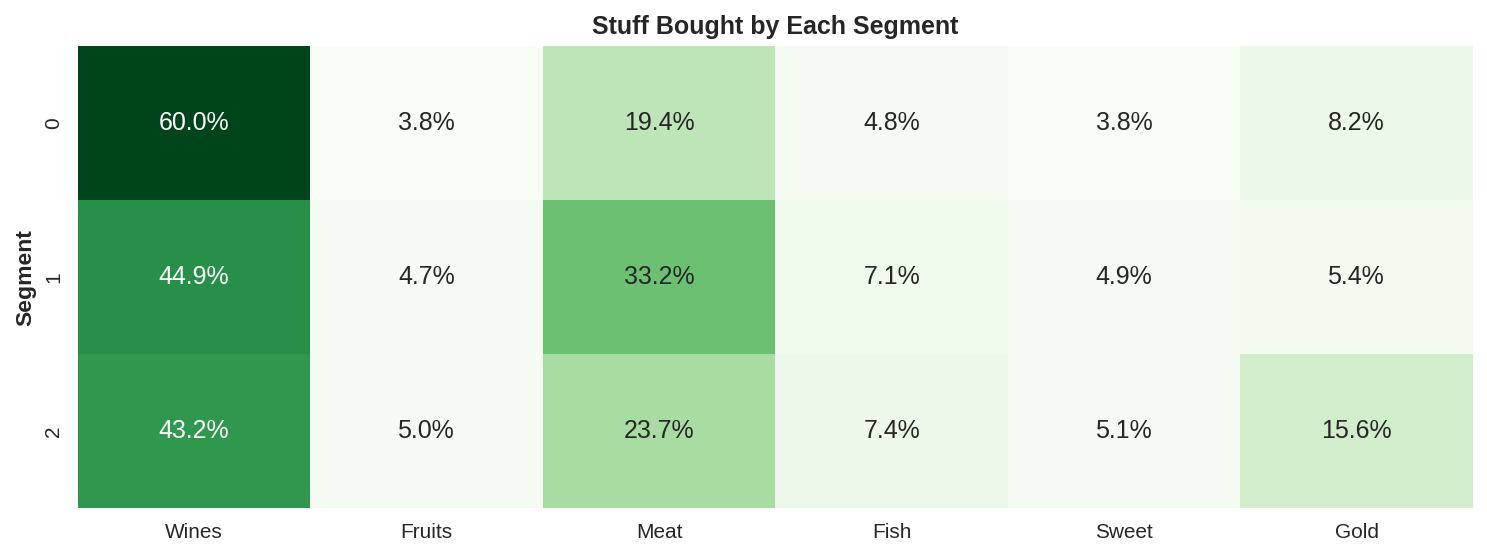

In [ ]:
y= 'segment'

data= (df
    .loc[:, df.columns.str.contains('mnt|segment', regex= True)]
    .groupby(y)
    .mean()
    .apply(lambda x: (x/x.sum()), axis= 'columns')
)

module.plot_heatmap(data, 'Stuff Bought by Each Segment')

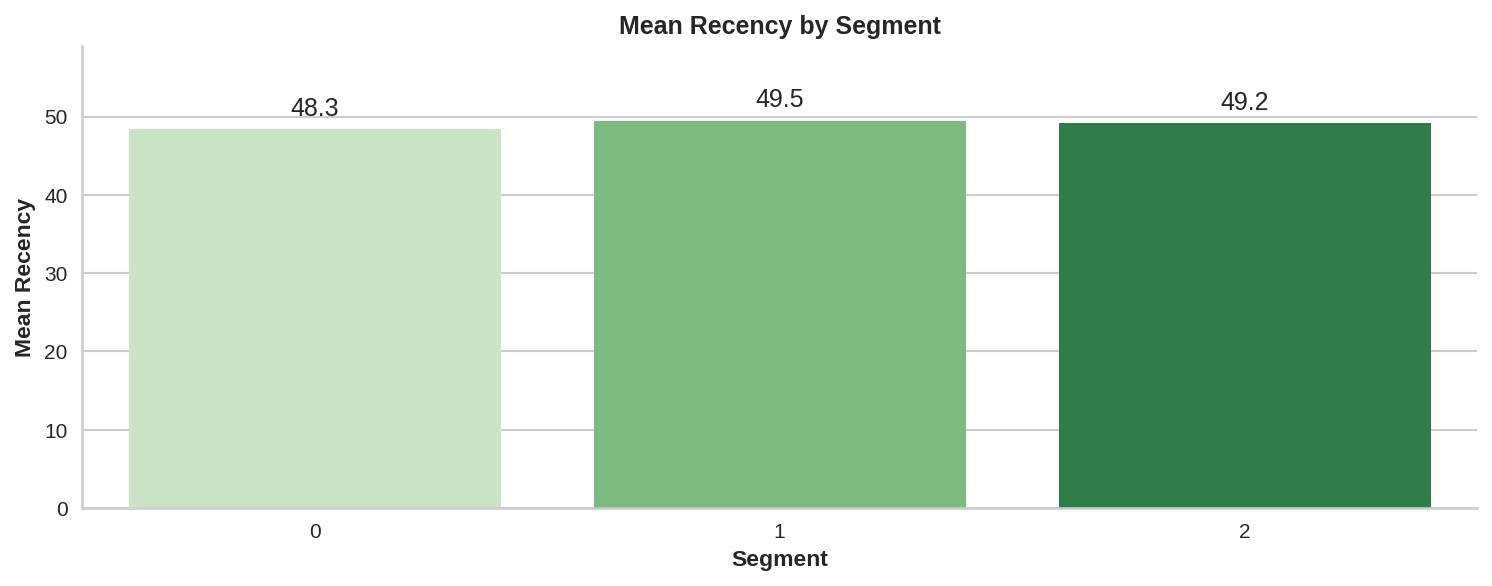

In [ ]:
data= (df
    .groupby('segment')
    .agg(mean_recency= ('recency', 'mean'))
    .reset_index()
)
module.plot_bar(
    x= 'segment', 
    y= 'mean_recency', 
    df= data, 
    ylim= (0, 59)
)

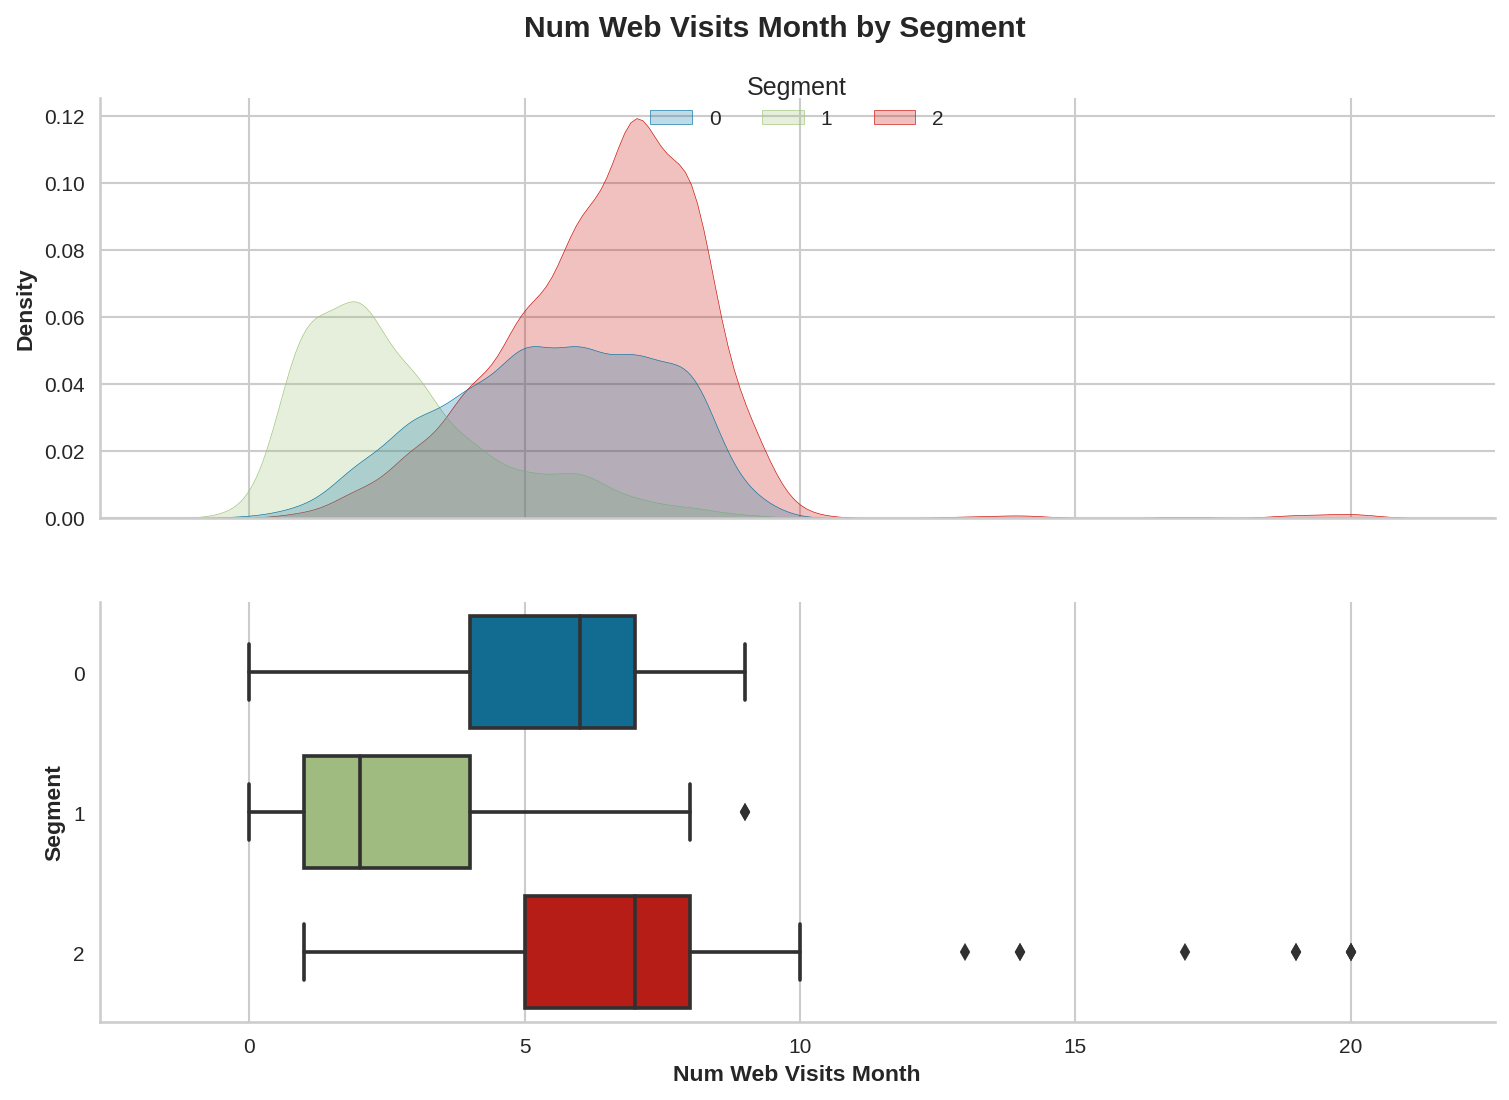

In [ ]:
module.plot_kde_box(y= 'segment', x= 'num_web_visits_month', df= df)

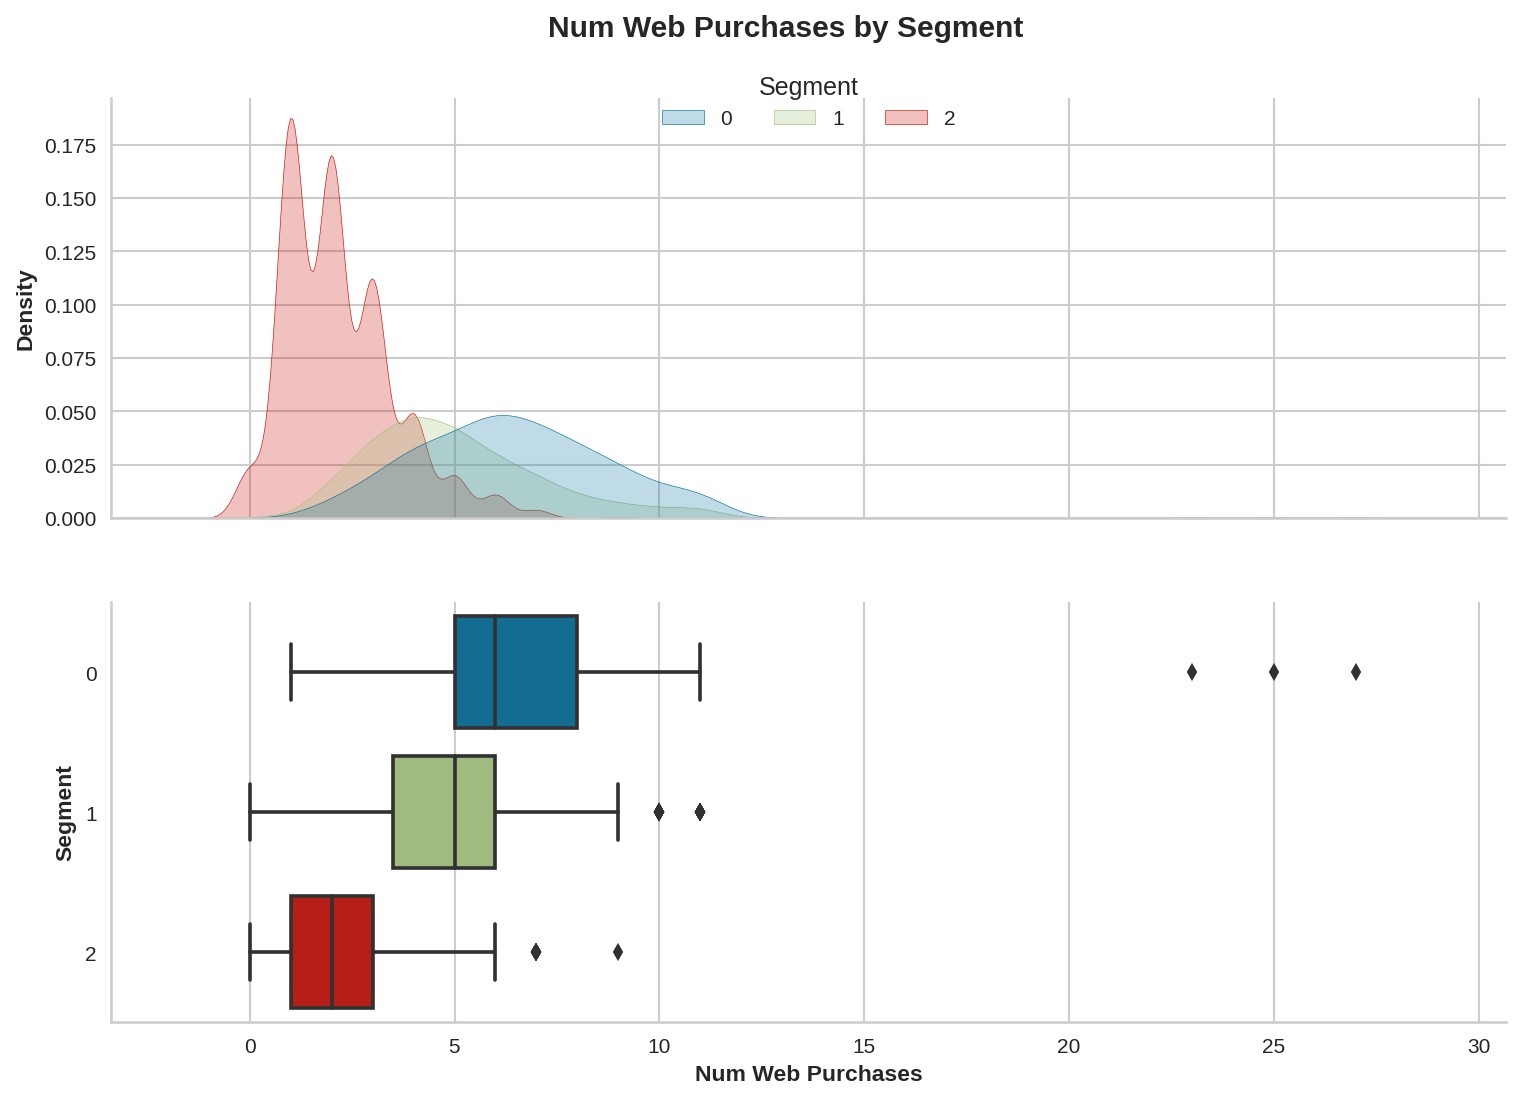

In [ ]:
module.plot_kde_box(y= 'segment', x= 'num_web_purchases', df= df)

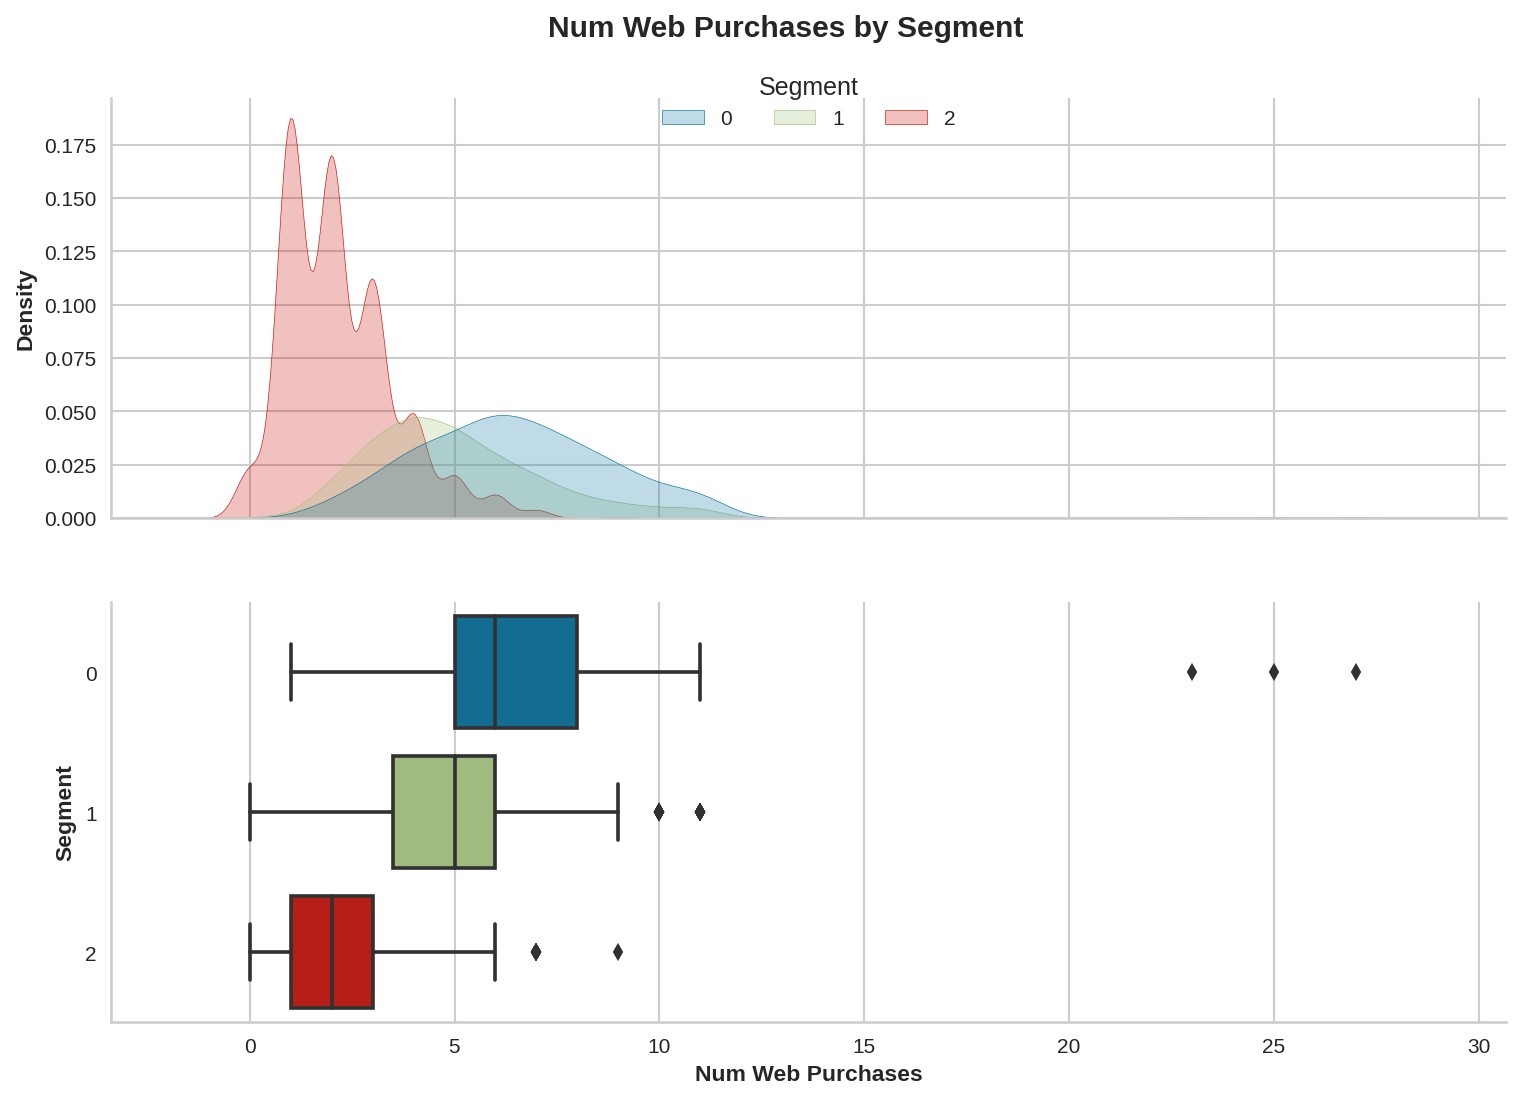

In [ ]:
module.plot_kde_box(y= 'segment', x= 'num_web_purchases', df= df)

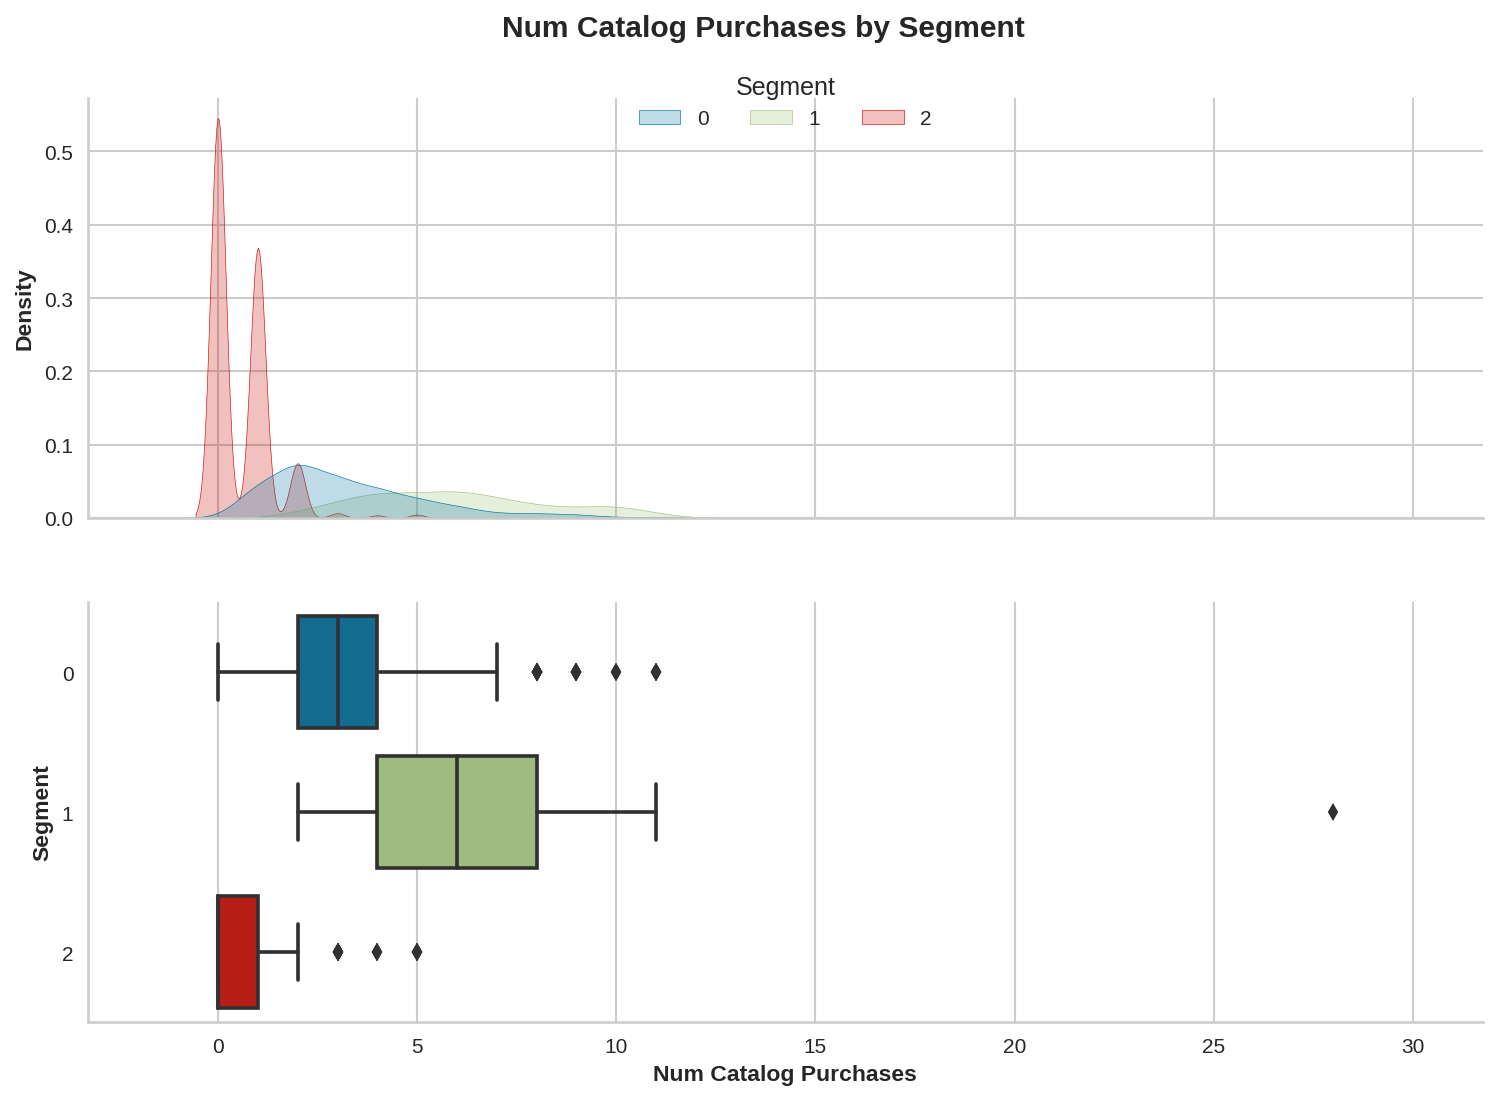

In [ ]:
module.plot_kde_box(y= 'segment', x= 'num_catalog_purchases', df= df)

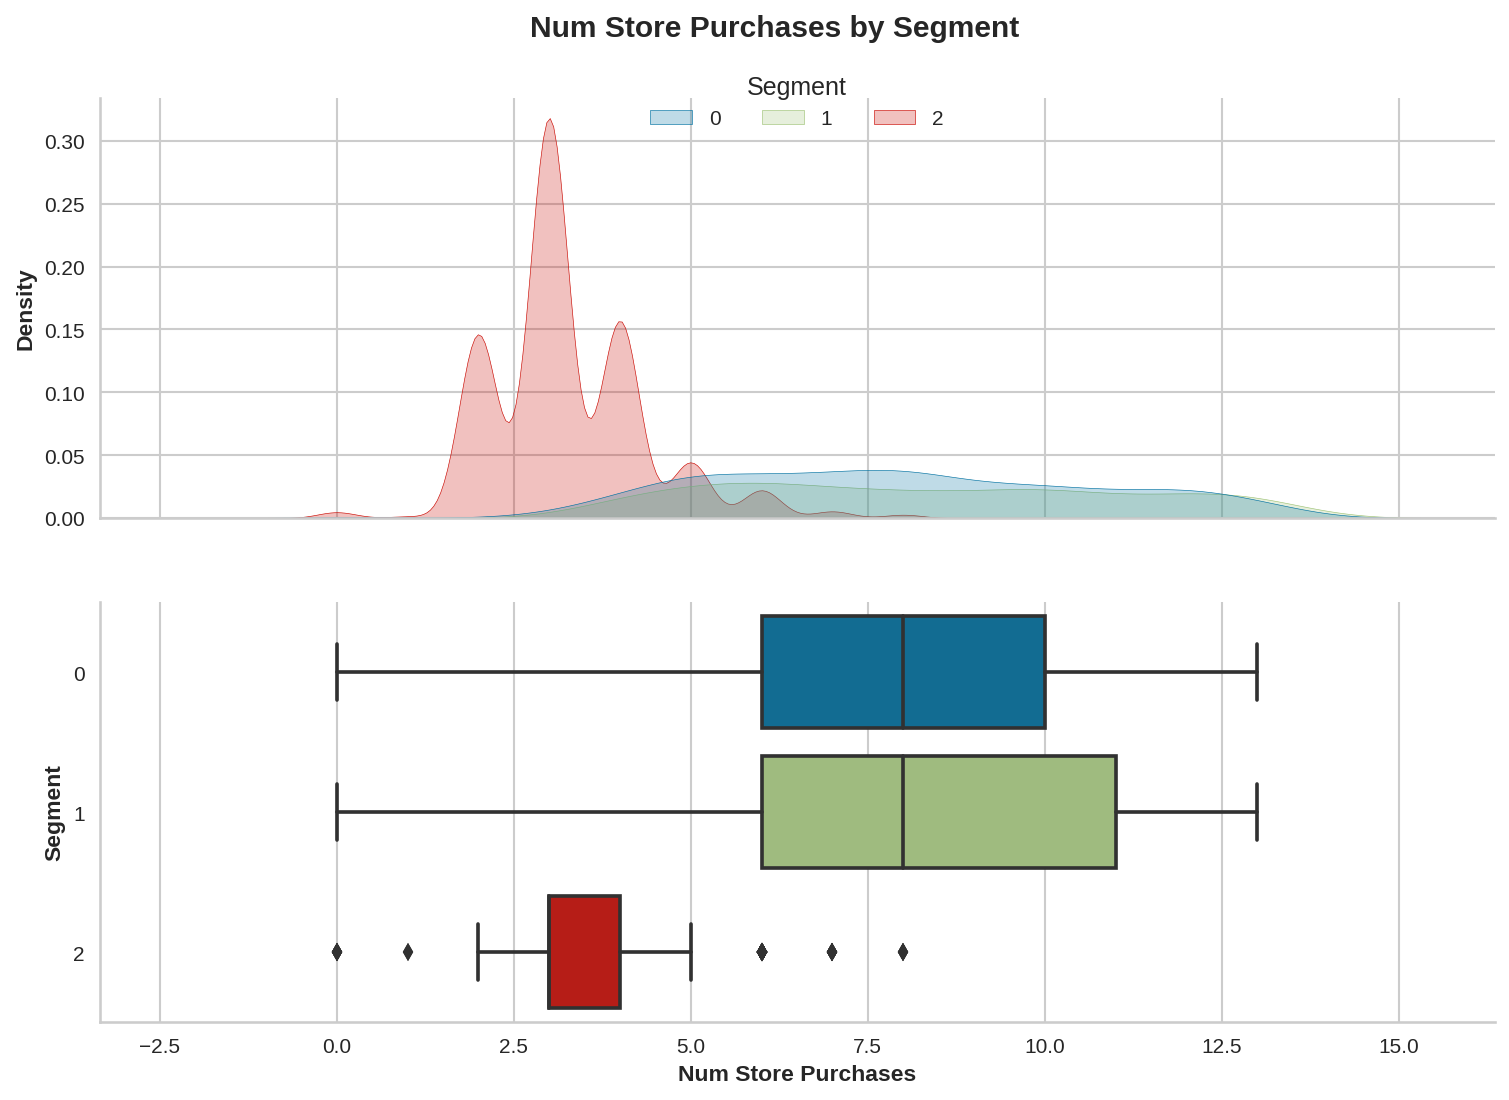

In [ ]:
module.plot_kde_box(y= 'segment', x= 'num_store_purchases', df= df)

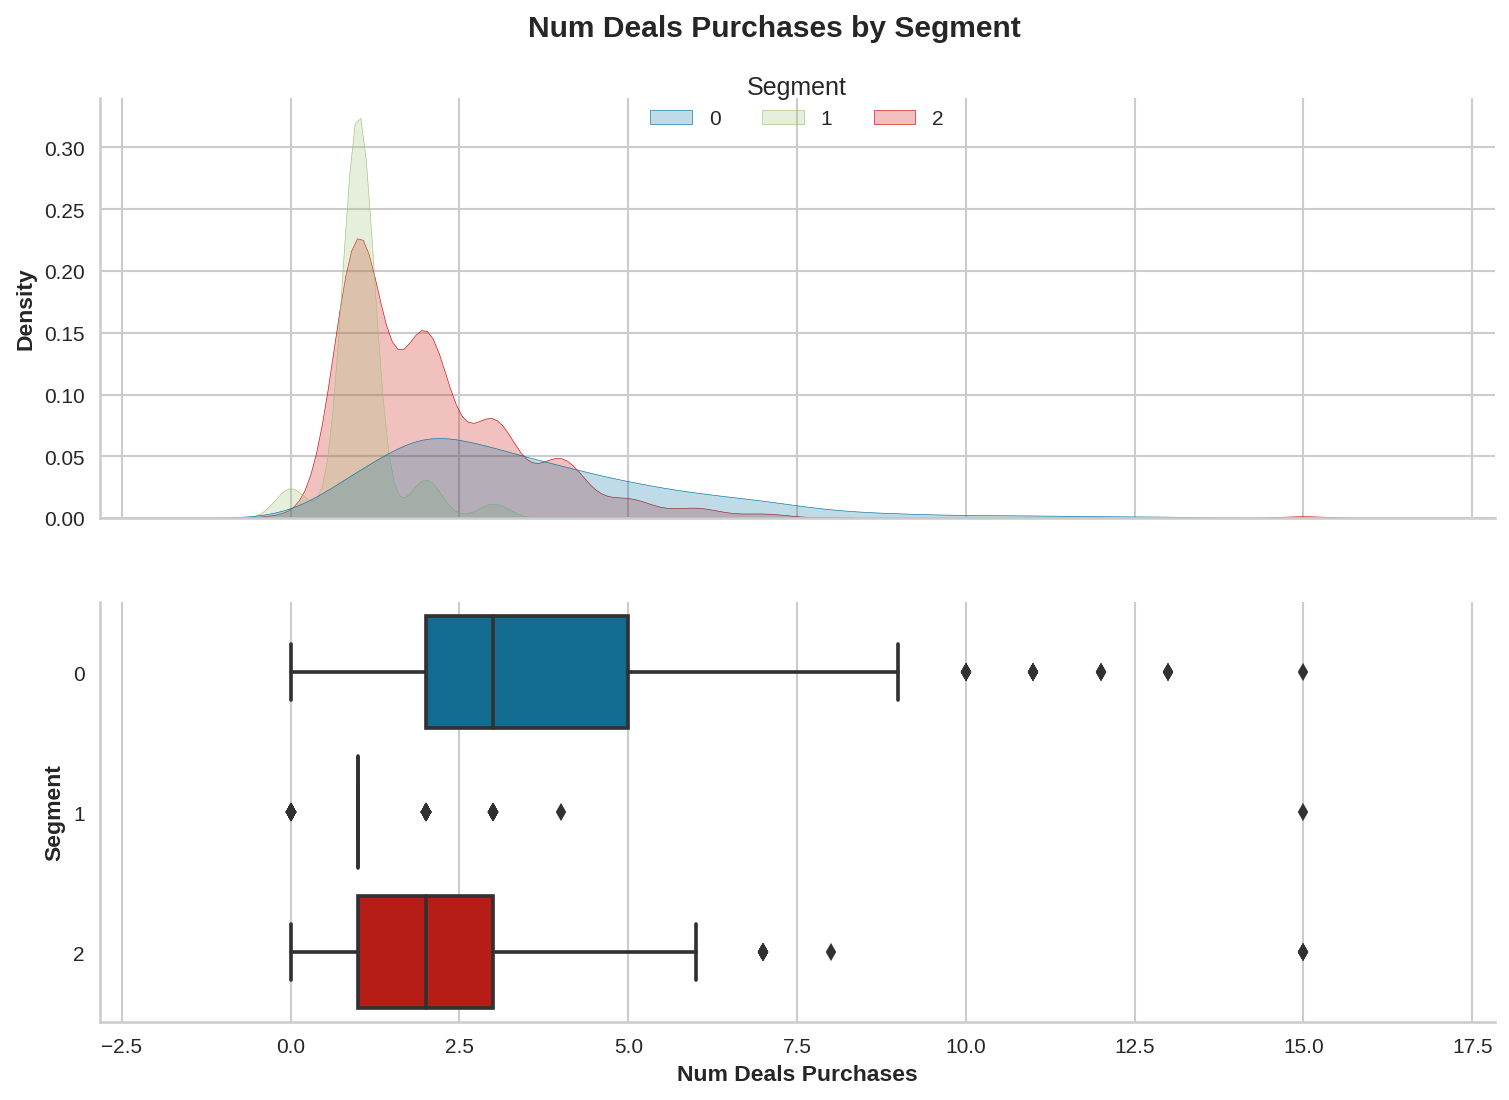

In [ ]:
module.plot_kde_box(y= 'segment', x= 'num_deals_purchases', df= df)

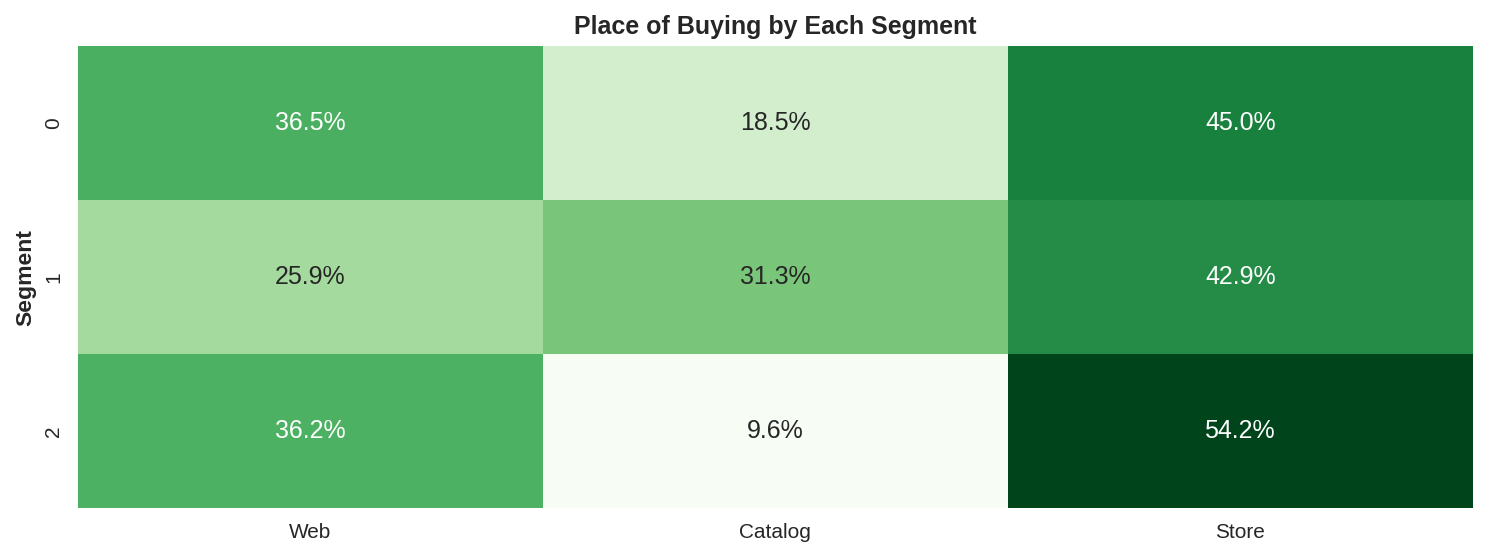

In [ ]:
y= 'segment'

data= (df
    .loc[:, df.columns.str.contains('purchases|segment', regex= True)]
    .drop(columns= 'num_deals_purchases')
    .groupby(y)
    .mean()
    .apply(lambda x: (x/x.sum()), axis= 'columns')
)
module.plot_heatmap(data, 'Place of Buying by Each Segment')

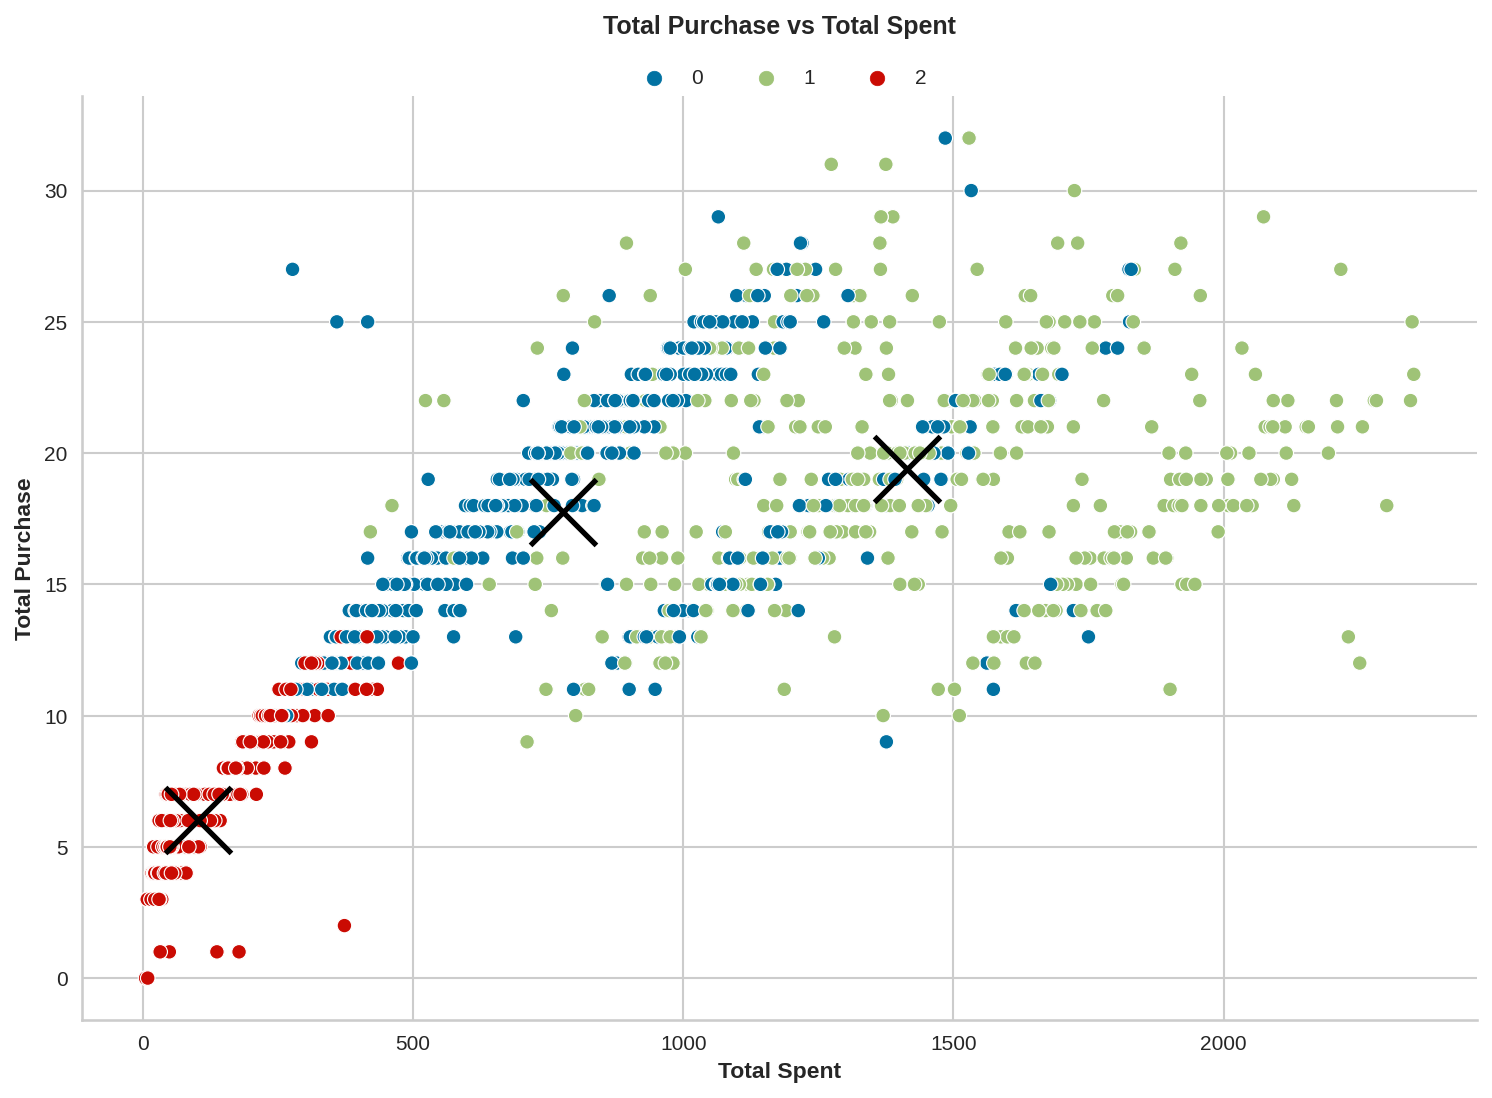

In [ ]:
module.plot_scatter_with_centroids(
    x= 'total_spent',
    y= 'total_purchase',
    scaler= scaler, 
    model= kmeans, 
    df= df
)

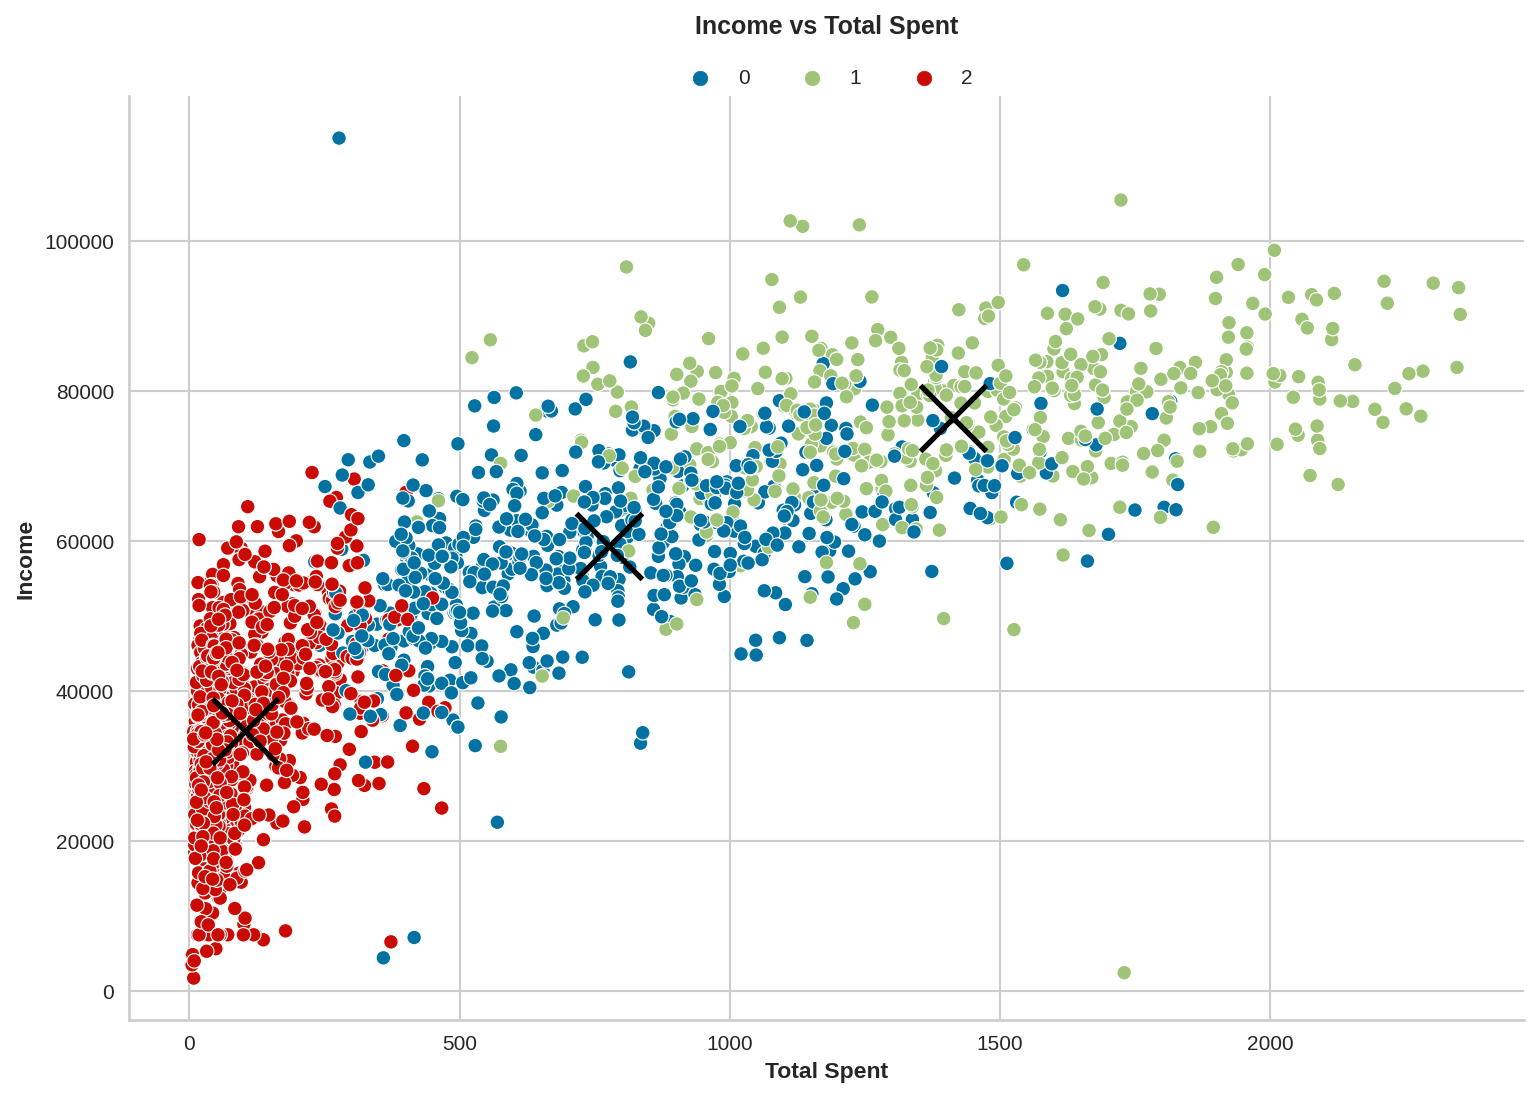

In [ ]:
module.plot_scatter_with_centroids(
    x= 'total_spent',
    y= 'income',
    scaler= scaler, 
    model= kmeans, 
    df= df
)

### Segment Profile